This notebook reproduces the excitatory-inhibitory example on the homepage of Brian.

In [1]:
include("../spikenet/spikenet.jl")

SpikeNet

In [ ]:
using SpikeNet
using Parameters
using PyPlot
using Images

Define the state and update rules for a population of LIF neurons:

In [3]:
@with_kw struct LIF <: Group{:v}
    ge::Vector{Float32}
    gi::Vector{Float32}
    v::Vector{Float32}
    θ::Float32 = -50.0
    ρ::Float32 = -60.0
    τ::Float32 = 20.0
    τe::Float32 = 5.0
    τi::Float32 = 10.0
    dt::Float32 = 1.0    
end

LIF(N::Int; args...) = LIF(
    ge = fill(0.0f0, N),
    gi = fill(0.0f0, N),
    v = fill(-60.0f0, N),
    args...)

LIF

In [4]:
@generated on_update(lif::Elem{LIF}) = @resolve(quote
    if v > θ
        v = ρ
    end
    v += (ge + gi - (v + 49.f0)) * (dt/τ)
    ge -= ge * (dt/τe)
    gi -= gi * (dt/τi)
end, lif)

@generated has_spike(lif::Elem{LIF}) = @resolve(:(v > θ), lif)

has_spike (generic function with 1 method)

Define some simple weighted synapses:

In [5]:
struct Synapses <: Group{:w}
    w::Vector{Float32}
end
Synapses(N::Int, w0=0.0f0) = Synapses(fill(w0, N))

Synapses

In [6]:
@generated on_pre_spike(pre, syn::Elem{<:Synapses}, post::Elem{<:LIF}) = @resolve(quote
    if w > zero(w)
        ge_post += w
    else
        gi_post += w
    end
end, syn, post=post)

on_pre_spike (generic function with 1 method)

Define the simulation main loop:

In [7]:
route_spikes(pathway, test) = on_pre_spike.(pathway, test)

function run(duration, pop_e, pop_i, pathways)
    steps = 1:duration
    e_spikes = RecordedSpikes(pop_e, steps)
    i_spikes = RecordedSpikes(pop_i, steps)
    for s in steps
        on_update.(pop_e)
        on_update.(pop_i)
        route_spikes.(pathways, has_spike)
        record!(e_spikes, s, has_spike)
        record!(i_spikes, s, has_spike)
    end
    e_spikes, i_spikes
end

run (generic function with 1 method)

Build the network:

In [8]:
srand(hash("spikenet"))

pop_e = LIF(3200)
pop_i = LIF(800)

e_syns(N) = Synapses(N, 1.62f0)
i_syns(N) = Synapses(N, -9.0f0)

pathways = (
    SparsePathway(pop_e, pop_e, 0.02, e_syns),
    SparsePathway(pop_e, pop_i, 0.02, e_syns),
    SparsePathway(pop_i, pop_e, 0.02, i_syns),
    SparsePathway(pop_i, pop_i, 0.02, i_syns),
);

Let's run the network for one step to prime the JIT and get meaningful timings:

In [9]:
@time run(1, pop_e, pop_i, pathways);

  3.616885 seconds (2.18 M allocations: 116.427 MiB, 1.45% gc time)


Now let's do a one-second run:

In [10]:
@time e_spikes, i_spikes = run(1000, pop_e, pop_i, pathways);

  0.096060 seconds (486 allocations: 1014.688 KiB)


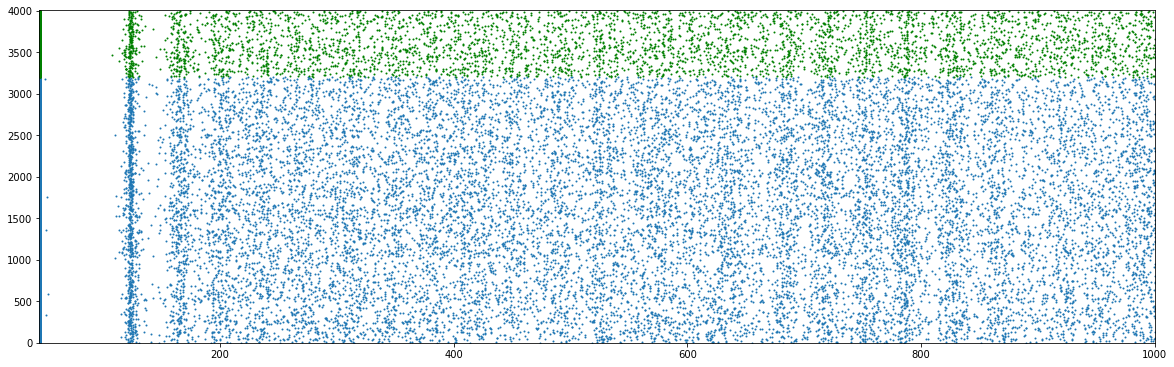

In [11]:
fig = figure(figsize=(20,6))
scatter(e_spikes.ts, e_spikes.id, s=1.0)
scatter(i_spikes.ts, i_spikes.id+length(pop_e), s=1.0, c="g")
autoscale(tight=true)
display(fig)
close(fig)

And now a longer 5 minute run:

In [12]:
@time e_spikes, i_spikes = run(5*60*1000, pop_e, pop_i, pathways);

 17.799329 seconds (455 allocations: 146.509 MiB, 0.77% gc time)


That's too much data for a scatter plot, so let's rasterise the spikes into 300 ms / 10 neuron bins:

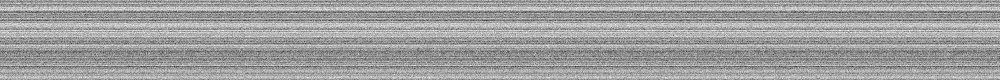

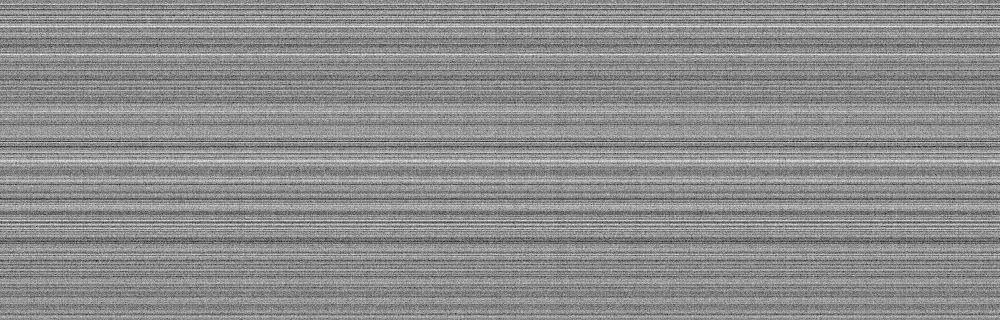

In [13]:
for spikes in (i_spikes, e_spikes)
    img = raster_spikes(spikes, 300, 10)
    display(colorview(Gray, sqrt.(img/maximum(img)))) # gamma correction to enhance contrast
end